<a href="https://colab.research.google.com/github/ashishthomaschempolil/Medical-Image-Captioning-on-Chest-X-rays/blob/main/2_Simple_encoder_decoder_Medical_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
image_folder = '/content/drive/My Drive/Medical image Reporting/Images'
df_path = '/content/drive/My Drive/Medical image Reporting/df_final.pkl'
chexnet_weights = '/content/drive/My Drive/Medical image Reporting/ChexNet weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="false" #https://github.com/tensorflow/tensorflow/issues/33721#issuecomment-577307175

# **Creating Tokenizer**

In [3]:
df = pd.read_pickle(df_path)
col = ['image_1','image_2','impression']
df = df[col].copy()
#path
df['image_1'] = df['image_1'].apply(lambda row: os.path.join(image_folder,row)) #https://stackoverflow.com/a/61880790
df['image_2'] = df['image_2'].apply(lambda row: os.path.join(image_folder,row))

df['impression_final'] = '<CLS> ' + df.impression + ' <END>'
df['impression_ip'] = '<CLS> ' + df.impression
df['impression_op'] = df.impression + ' <END>' 
print(df.shape)
df.head(2)

(4033, 6)


image_1  ...                                      impression_op
0  /content/drive/My Drive/Medical image Reportin...  ...  bilateral lower lobe opacities . the appearanc...
1  /content/drive/My Drive/Medical image Reportin...  ...  bilateral lower lung airspace disease right gr...

[2 rows x 6 columns]

In [4]:
df['impression'].value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                                                                                                                                                                                     383
no acute cardiopulmonary findings .                                                                                                                                                                                                                                                                                                                                                        172
no acute cardiopulmonary disease .                                                                                                                                                                                                        

Here we can see that some captions have only 1 values in the entire dataset while some datasets are having more than 5. What I will do here is that I will upsample all those datapoint which impression value counts <=5. First I will split the data into train and test only considering those datapoints which have value counts greater than 5 and applying stratify on impression column. 

In [5]:
#adding a new column impression counts which tells the total value counts of impression of that datapoint 
k = df['impression'].value_counts()
df = df.merge(k,
         left_on = 'impression',
         right_index=True) #join left impression value with right index

df.columns

Index(['impression', 'image_1', 'image_2', 'impression_x', 'impression_final',
       'impression_ip', 'impression_op', 'impression_y'],
      dtype='object')

In [6]:
df.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] #changin column names
del df['impression_x'] #deleting impressio_x column
df.head() 

impression  ... impression_counts
0    bilateral lower lobe opacities . the appearanc...  ...                 1
1    bilateral lower lung airspace disease right gr...  ...                 1
2                     negative for acute abnormality .  ...                31
142                   negative for acute abnormality .  ...                31
149                   negative for acute abnormality .  ...                31

[5 rows x 7 columns]

Here my approach is that I will divide the data into two one with all the impression value counts greater than 5 (other1) and other being <=5 (other2). Then split the data with test_size=0.5. A sample of 0.2*other2.shape[0] will be then taken and will be added on to the test data that was split. The other data from the other2 will be appended to train.

In [7]:
from sklearn.model_selection import train_test_split
other1 = df[df['impression_counts']>5] #selecting those datapoints which have impression valuecounts >5
other2 = df[df['impression_counts']<=5] #selecting those datapoints which have impression valuecounts <=5
train,test = train_test_split(other1,stratify = other1['impression'].values,test_size = 0.5,random_state = 420)
test_other2_sample = other2.sample(int(0.2*other2.shape[0]),random_state = 420) #getting some datapoints from other2 data for test data
other2 = other2.drop(test_other2_sample.index,axis=0)
#here i will be choosing 0.5 as the test size as to create a reasonable size of test data
test = test.append(test_other2_sample)
test = test.reset_index(drop=True)

train = train.append(other2) 
train = train.reset_index(drop=True)
train.shape[0],test.shape[0]

(2590, 1443)

Now we will upsample and downsample certain datapooints.

In [8]:
from sklearn.utils import resample
df_majority = train[train['impression_counts']>=100]
df_minority = train[train['impression_counts']<=5]
df_other = train[(train['impression_counts']>5)&(train['impression_counts']<100)]
n1 = df_minority.shape[0]
n2 = df_majority.shape[0]
n3 = df_other.shape[0]
#we will upsample them to 30
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//7,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n2//2,
                                 random_state = 420)

train = pd.concat([df_majority ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(5403, 7)

In [9]:
# folder_name = '/content/drive/MyDrive/Medical image Reporting/pickle_files'
# file_name = 'train.pkl'
# train.to_pickle(os.path.join(folder_name,file_name))

# file_name = 'test.pkl'
# test.to_pickle(os.path.join(folder_name,file_name))

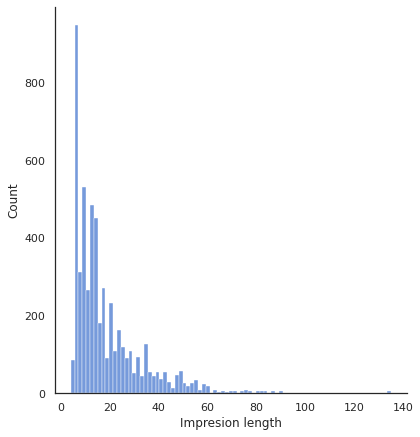


Value Counts for caption length top 5 values

Length|Counts
7     695
8     313
9     271
12    270
11    266
dtype: int64

The max and min value of "caption length" was found to be 135 and 4 respectively
The 95 percentile value of caption_len which is 49 will be taken as the maximum padded value for each impression


In [10]:
#tokenizer
tokenizer = Tokenizer(filters = '',oov_token = '<unk>') #setting filters to none
tokenizer.fit_on_texts(train.impression_final.values)
train_captions = tokenizer.texts_to_sequences(train.impression_final) 
test_captions = tokenizer.texts_to_sequences(test.impression_final) 
vocab_size = len(tokenizer.word_index)
caption_len = np.array([len(i) for i in train_captions])
start_index = tokenizer.word_index['<cls>'] #tokened value of <cls>
end_index = tokenizer.word_index['<end>'] #tokened value of <end>
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'

#visualising impression length and other details
ax = sns.displot(caption_len,height = 6)
ax.set_titles('Value Counts vs Caption Length')
ax.set_xlabels('Impresion length')
plt.show()
print('\nValue Counts for caption length top 5 values\n')
print('Length|Counts')
print(pd.Series(caption_len).value_counts()[:5])
print('\nThe max and min value of "caption length" was found to be %i and %i respectively'%(max(caption_len),min(caption_len)))
print('The 95 percentile value of caption_len which is %i will be taken as the maximum padded value for each impression'%(np.percentile(caption_len,95)))
max_pad = int(np.percentile(caption_len,95))
del train_captions,test_captions #we will create tokenizing  and padding in-built in dataloader

# **Modelling**

## **Hyperparameters**

In [11]:
batch_size = 100
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

## **Creating an input data pipeline**

In [12]:
class Dataset():
  #here we will get the images converted to vector form and the corresponding captions
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size #tuple ex: (512,512)
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

    #image augmentation
    #https://imgaug.readthedocs.io/en/latest/source/overview/flip.html?highlight=Fliplr
    self.aug1 = iaa.Fliplr(1) #flip images horizaontally
    self.aug2 = iaa.Flipud(1) #flip images vertically

    # https://imgaug.readthedocs.io/en/latest/source/overview/convolutional.html?highlight=emboss#emboss
    self.aug3 = iaa.Emboss(alpha=(1), strength=1) #embosses image

    #https://imgaug.readthedocs.io/en/latest/source/api_augmenters_convolutional.html?highlight=sharpen#imgaug.augmenters.convolutional.Sharpen
    self.aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5)) #sharpens the image and apply some lightness/brighteness 1 means fully sharpened etc

  def __getitem__(self,i):
    #gets the datapoint at i th index, we will extract the feature vectors of images after resizing the image  and apply augmentation
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255 #here there are 3 channels
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
    if image1.any()==None:
      print("%i , %s image sent null value"%(i,self.image1[i]))
    if image2.any()==None:
      print("%i , %s image sent null value"%(i,self.image2[i]))


    #tokenizing and padding
    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') #opshape:(input_length,)
    caption = tf.squeeze(caption,axis=0) #opshape = (input_length,) removing unwanted axis if present

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) #the input should be an array for tokenizer ie [self.caption[i]] 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') #opshape: (input_length,)
    caption1 = tf.squeeze(caption1,axis=0) #opshape = (input_length,) removing unwanted axis if present




    if self.augmentation: #we will not apply augmentation that crops the image 
          a = np.random.uniform()
          if a<0.2:
              image1 = self.aug1.augment_image(image1)
              image2 = self.aug1.augment_image(image2)
          elif a<0.4:
              image1 = self.aug2.augment_image(image1)
              image2 = self.aug2.augment_image(image2)
          elif a<0.6:
              image1 = self.aug3.augment_image(image1)
              image2 = self.aug3.augment_image(image2)
          elif a<0.8:
              image1 = self.aug4.augment_image(image1)
              image2 = self.aug4.augment_image(image2)
          else: #applying no augmentation
            pass;

    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     #for batching
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [self.dataset[j] for j in range(start,stop)] #taken from Data class (calls __getitem__ of Data) here the shape is batch_size*3, (image_1,image_2,caption)
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] #here the shape will become batch_size*input_size(of image)*3,batch_size*input_size(of image)*3
                                                                      #,batch_size*1*max_pad


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) #here [image1,image2, caption(without <END>)],caption(without <CLS>) (op)
    
    def __len__(self): #returns total number of batches in an epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): #it runs at the end of epoch
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [13]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_size)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_size)

## **CHeXNET Model (pretrained)**

[CheXNET Model](https://arxiv.org/pdf/1711.05225.pdf) is a Denset121 layered model which is trained on 1000s of chest x-ray images for the classification of 14 diseases.We can load the weights of that model and pass the image through that model. The top layer will be ignore.

In [14]:
#chexnet weights ; https://drive.google.com/file/d/19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b/view
def create_chexnet(chexnet_weights = chexnet_weights):
  """
  chexnet_weights: weights value in .h5 format of chexnet
  creates a chexnet model with preloaded weights present in chexnet_weights file
  """
  model = tf.keras.applications.DenseNet121(include_top=False) #importing densenet the last layer will be a relu activation layer

  #we need to load the weights so setting the architecture of the model as same as the one of tha chexnet
  x = model.output #output from chexnet
  x = GlobalAveragePooling2D()(x)
  x = Dense(14, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

  chexnet = tf.keras.Model(inputs = model.input,outputs = x)
  chexnet.load_weights(chexnet_weights)
  chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.layers[-2].output)  #we will be taking the penultimate layer (second last layer here it is global avgpooling)
  return chexnet

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



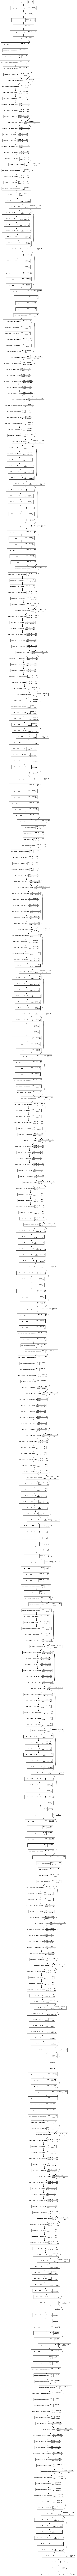

In [21]:
chexnet = create_chexnet()
chexnet.trainable = False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)


In [22]:
del chexnet

## Simple Encoder Decoder Model

### Image Encoder Layer

In [23]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = create_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data)
    return op

### Model

In [24]:
embedding_dim = 300
dense_dim = 512
lstm_units = dense_dim
dropout_rate = 0.2

In [25]:
glove = {}
with open('/content/drive/My Drive/glove_vectors/glove.6B.300d.txt',encoding='utf-8') as f: #taking 300 dimesions
  for line in f:
    word = line.split() #it is stored as string like this "'the': '.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.4"
    glove[word[0]] = np.asarray(word[1:], dtype='float32')


embedding_dim = 300
# create a weight matrix for words in training docs for embedding purpose
embedding_matrix = np.zeros((vocab_size+1, embedding_dim)) #https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

for word, i in tokenizer.word_index.items():
  embedding_vector = glove.get(word)
  if embedding_vector is not None: #if the word is found in glove vectors
      embedding_matrix[i] = embedding_vector[:embedding_dim]

In [26]:
tf.keras.backend.clear_session()
image1 = Input(shape = (input_size + (3,))) #shape = 224,224,3
image2 = Input(shape = (input_size + (3,))) #https://www.w3resource.com/python-exercises/tuple/python-tuple-exercise-5.php
caption = Input(shape = (max_pad,))




img1_encoder = Image_encoder() #contains chexnet model which is set trainable  =  False
img2_encoder = Image_encoder() #opshape: (?,1024)
bk_feat1 = img1_encoder(image1)
bk_feat1 = Dense(dense_dim,
                 activation = 'relu',
                 name = 'bk_dense_1'
                  )(bk_feat1) #dense for the first image op: (?,dense_dim)

bk_feat2 = img2_encoder(image2)
bk_feat2 = Dense(dense_dim,
                 activation = 'relu',
                 name = 'bk_dense_2'
                  )(bk_feat2) #dense for the 2nd image op: (?,dense_dim)

bk_features_concat = Concatenate(axis=-1)([bk_feat1,bk_feat2]) #concatenating the backbone images op_shape: (?,1024)
bk_features_concat = BatchNormalization()(bk_features_concat) #applying batch norm
bk_features_concat = Dropout(dropout_rate)(bk_features_concat) 
image_dense = Dense(dense_dim,
                    activation = 'relu',
                    name = 'Image_dense',
                    use_bias='False'

                    )

                    
image_bkbone = image_dense(bk_features_concat) #final op from dense op_shape: (?,dense_dim) this will be added as initial states to the lstm
image_dense_op = tf.keras.backend.expand_dims(image_bkbone,axis=1) #op_shape: (?,1,dense_dim)



embedding = Embedding(input_dim  = vocab_size+1,
                              output_dim = embedding_dim,
                              input_length = max_pad,
                              mask_zero = True,
                              weights = [embedding_matrix],
                              name = 'embedding'
                              )
embed_op = embedding(caption) #op_shape: (?,input_length,embedding_dim)






lstm_layer = LSTM(units = lstm_units,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embed_op,initial_state = [image_bkbone,image_bkbone]) #op_shape = batch_size*input_length*lstm_units

lstm_op = BatchNormalization()(lstm_op)
add = Add()([image_dense_op,lstm_op]) #op_shape: (?,input_lenght,lstm_units/dense_dim) here lstm_dims=dense_dim

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)

In [27]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
image_encoder (Image_encoder)   (None, 1024)         7037504     input_1[0][0]                    
__________________________________________________________________________________________________
image_encoder_1 (Image_encoder) (None, 1024)         7037504     input_2[0][0]                    
_______________________________________________________________________________________

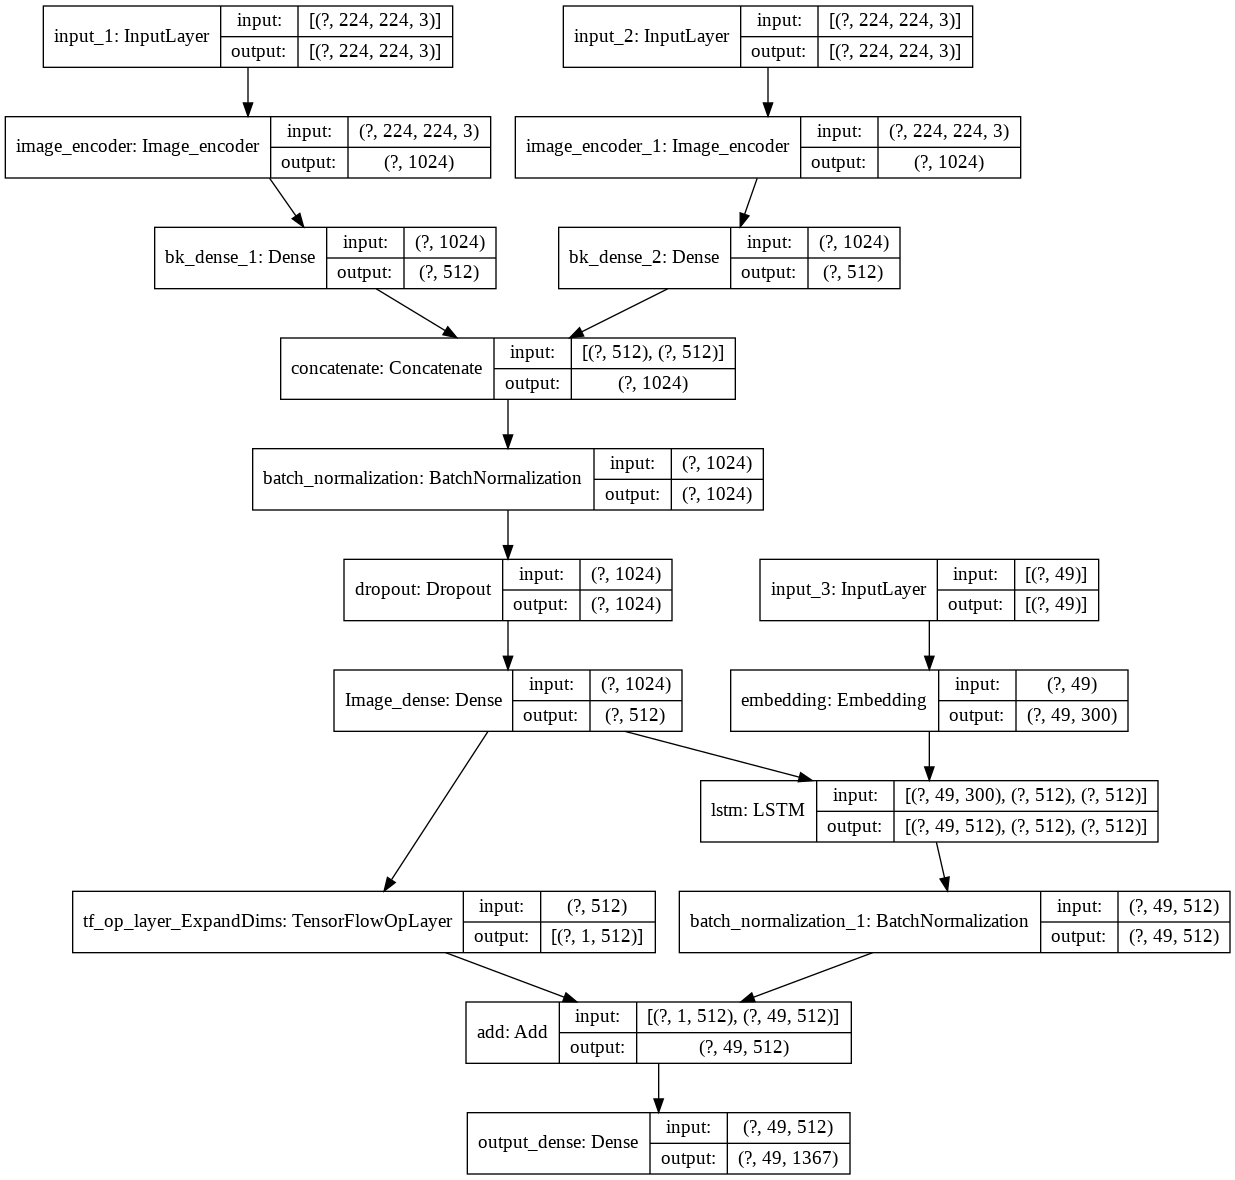

In [28]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [29]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-2
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [30]:
tf.keras.backend.clear_session()
tb_filename = 'Simple_Encoder_Decoder/'
tb_file = os.path.join('/content/drive/My Drive/Medical image Reporting',tb_filename)
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/content/drive/My Drive/Medical image Reporting',model_filename)
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5,
                                     verbose = 2
                                     ),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save,
                                       save_best_only = True,
                                      save_weights_only = True,
                                       verbose = 2
                                       ),
    tf.keras.callbacks.TensorBoard(histogram_freq=1,
                                   log_dir=tb_file),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=10**-7, verbose = 2)
                                   
] #from keras documentation

In [ ]:
!rm -r '/content/drive/My Drive/Medical image Reporting/Simple_Encoder_Decoder/'

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 20,
          callbacks = my_callbacks
          )

Epoch 1/20
 1/54 [..............................] - ETA: 0s - loss: 1.1102 - accuracy: 5.2966e-04WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
54/54 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.3303 
Epoch 00001: val_loss improved from inf to 0.23997, saving model to /content/drive/My Drive/Medical image Reporting/Simple_Encoder_Decoder.h5
54/54 [==============================] - 2895s 54s/step - loss: 0.2279 - accuracy: 0.3303 - val_loss: 0.2400 - val_accuracy: 0.0000e+00
Epoch 2/20
54/54 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.5467
Epoch 00002: val_loss improved from 0.23997 to 0.23997, saving model to /content/drive/My Drive/Medical image Reporting/Simple_Encoder_Decoder.h5
54/54 [================

In [31]:
model_filename = 'Simple_Encoder_Decoder.h5'
model_save = os.path.join('/content/drive/My Drive/Medical image Reporting',model_filename)
model1 = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)
model1.load_weights(model_save)

In [32]:
%load_ext tensorboard

In [33]:
%tensorboard --logdir '/content/drive/My Drive/Medical image Reporting/'

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 211.

## **Predictions**

We will compute bleu scores 1-gram,2-gram, 3-gram and 4-gram for each sentence.

In [34]:
def get_bleu(reference,prediction):
  """
  Given a reference and prediction string, outputs the 1-gram,2-gram,3-gram and 4-gram bleu scores
  """
  reference = [reference.split()] #should be in an array (cos of multiple references can be there here only 1)
  prediction = prediction.split()
  bleu1 = sentence_bleu(reference,prediction,weights = (1,0,0,0),)
  bleu2 = sentence_bleu(reference,prediction,weights = (0.5,0.5,0,0))
  bleu3 = sentence_bleu(reference,prediction,weights = (0.33,0.33,0.33,0))
  bleu4 = sentence_bleu(reference,prediction,weights = (0.25,0.25,0.25,0.25))

  return bleu1,bleu2,bleu3,bleu4

In [35]:
#calculate bleu scores for every datapoint
def mean_bleu(test,predict):
  """
  given a df and predict fucntion which predicts the impression of the caption
  outpus the mean bleu1,bleu2,bleu3, bleu4 for entire datapoints in df
  """
  bleu1,bleu2,bleu3,bleu4 = [],[],[],[]
  for index,data in test.iterrows():
    predict_val = predict(data['image_1'],data['image_2']) #predicted sentence
    true = data.impression
    _ = get_bleu(true,predict_val)
    bleu1.append(_[0])
    bleu2.append(_[1])
    bleu3.append(_[2])
    bleu4.append(_[3])
  return np.array(bleu1).mean(),np.array(bleu2).mean(),np.array(bleu3).mean(),np.array(bleu4).mean()

### **Greedy Search**

In [36]:
def greedy_search_predict(image1,image2,model = model1):
  """
  Given paths to two x-ray images predicts the impression part of the x-ray in a greedy search algorithm
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder_1')(image2)

  image1 = model.get_layer('bk_dense_1')(image1) #op from dense layer
  image2 = model.get_layer('bk_dense_2')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  concat = model.get_layer('batch_normalization')(concat)
  image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = model.get_layer('tf_op_layer_ExpandDims')(image_dense)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    caption = model.get_layer('batch_normalization_1')(caption)
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      a.append(tf.squeeze(max_prob).numpy())
  return tokenizer.sequences_to_texts([a])[0] #here output would be 1,1 so subscripting to open the array

In [ ]:
%%time
_ = mean_bleu(test,greedy_search_predict)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


CPU times: user 23min 41s, sys: 60 s, total: 24min 41s
Wall time: 19min 55s


In [ ]:
_

(0.20813931001253014,
 0.28850568897822493,
 0.3720987200922074,
 0.43989959861354017)

### **Beam Search**

In [37]:
def get_predictions(image1,image2, model=model1):
  """
  given image 1 and image 2 and model outputs prediction probabilities for each timestep upto chosen max pad of the model
  """
  image1 = cv2.imread(image1,cv2.IMREAD_UNCHANGED)/255 
  image2 = cv2.imread(image2,cv2.IMREAD_UNCHANGED)/255 
  image1 = tf.expand_dims(cv2.resize(image1,input_size,interpolation = cv2.INTER_NEAREST),axis=0) #introduce batch and resize
  image2 = tf.expand_dims(cv2.resize(image2,input_size,interpolation = cv2.INTER_NEAREST),axis=0)

  image1 = model.get_layer('image_encoder')(image1) #output from chexnet
  image2 = model.get_layer('image_encoder_1')(image2)

  image1 = model.get_layer('bk_dense_1')(image1) #op from dense layer
  image2 = model.get_layer('bk_dense_2')(image2)

  concat = model.get_layer('concatenate')([image1,image2])
  concat = model.get_layer('batch_normalization')(concat)
  image_dense = model.get_layer('Image_dense')(concat)
  bk_feat = model.get_layer('tf_op_layer_ExpandDims')(image_dense)


  states = [image_dense, image_dense]
  a = []
  pred = []
  for i in range(max_pad):
    if i==0: #if first word
      caption = np.array(tokenizer.texts_to_sequences(['<cls>'])) #shape: (1,1)
    caption= model.get_layer('embedding')(caption) #embedding shape = 1*1*300
    caption,state_h,state_c = model.get_layer('lstm')(caption,initial_state = states) #lstm 1*1*512
    caption = model.get_layer('batch_normalization_1')(caption)
    states = [state_h,state_c]

    add = model.get_layer('add')([bk_feat,caption]) #add
    output = model.get_layer('output_dense')(add) #1*1*vocab_size (here batch_size=1)

    #prediction
    max_prob = tf.argmax(output,axis=-1) #tf.Tensor of shape = (1,1)
    caption = np.array(max_prob) #will be sent to embedding for next iteration
    if max_prob==np.squeeze(tokenizer.texts_to_sequences(['<end>'])): 
      break;
    else:
      pred.append(output.numpy().squeeze()) #pred stores prob of every op at every timestep ie pred[0]: all prob at timestep 0
  return pred

In [38]:
#https://towardsdatascience.com/boosting-your-sequence-generation-performance-with-beam-search-language-model-decoding-74ee64de435a
def beam_search_decoder(predictions, top_k = 3):
  """
  given prediction ie probabilities for each and every timestep, 
  gets the top 3 sequences with highest probability based on beam search
  """
    #start with an empty sequence with zero score
  output_sequences = [([], 0)]
  
  #looping through all the predictions
  for token_probs in predictions:
      new_sequences = []
      
      #append new tokens to old sequences and re-score
      for old_seq, old_score in output_sequences:
          for sent_index in range(len(token_probs)): #iterating for each word in the vocab
              new_seq = old_seq + [sent_index]
              #considering log-likelihood for scoring (here log is considered because the probs values will be very small)
              new_score = old_score + math.log(token_probs[sent_index])
              new_sequences.append((new_seq, new_score))
              
      #sort all new sequences in the de-creasing order of their score
      output_sequences = sorted(new_sequences, key = lambda val: val[1], reverse = True)
      
      #select top-k based on score 
      # *Note- best sequence is with the highest score her
      output_sequences = output_sequences[:top_k]
        
  return output_sequences

In [39]:
def beam_search_predict(image1,image2,top_k=3,model=model1):
  pred = get_predictions(image1,image2,model)
  op_sequences = beam_search_decoder(pred,top_k)
  sentence = tokenizer.sequences_to_texts([op_sequences[0][0]]) #contains sequence, score
  return sentence[0]

In [ ]:
%%time
_ = mean_bleu(test,beam_search_predict)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


CPU times: user 28min 57s, sys: 1min 1s, total: 29min 59s
Wall time: 25min 6s


In [ ]:
_

(0.20813931001253014,
 0.28850568897822493,
 0.3720987200922074,
 0.43989959861354017)

In [ ]:
sentence_bleu(['This is not awesome'.split()],'This is awesome'.split(),weights = (.25,0.25,0.25,0.25))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.6025286104785453

# **Inference**

In [56]:
def final_caption_pred(image1,image2,method = "beam",top_k = 3,model=model1):
  """
  Given image1. image2 paths, the model, top_k and the method of prediction returns the predicted caption
  method: "greedy" or "g" for greedy search, "beam" or "b" for beam search
  """
  if method in ['greedy','g']:
    pred_caption = greedy_search_predict(image1,image2,model)
  elif method in ['beam','b']:
    pred_caption = beam_search_predict(image1,image2,top_k = top_k,model = model)
  else:
    print("Enter 'b' or 'beam' for beam search and 'g' or 'greedy' for greedy search")
  
  return pred_caption

In [83]:
def inference(image1,image2,true_caption,model=model1,top_k = [3,5,7],image_size = (20,40)):
  """
  given 2 images (their paths), the true caption, the model and the range of top_k
  prints the two images, true caption along with greedy search prediction and beam search prediction of top_k range
  """
  image1_array = cv2.imread(image1,cv2.IMREAD_UNCHANGED)
  image2_array = cv2.imread(image2,cv2.IMREAD_UNCHANGED)
  if type(top_k)==int:
    top_k = [top_k] #changing it to list if top_k given is of int type
  greedy_caption = final_caption_pred(image1,image2,method='g',model=model) #getting the greedy search prediction

  #printing the 2 images
  plt.figure(figsize = image_size)
  plt.subplot(121)
  plt.imshow(image1_array)
  plt.axis("off")

  plt.subplot(122)
  plt.imshow(image2_array)
  plt.axis("off")
  plt.show()

  print("\nTrue caption: '%s'"%(true_caption))
  print("Predicted caption(greedy search): '%s'"%(greedy_caption))
  #beam search of top_k
  for i in top_k:
    beam_caption = final_caption_pred(image1,image2,method='b',model=model,top_k = i)
    print("Predicted caption(beam search = %i): '%s'"%(i,beam_caption))


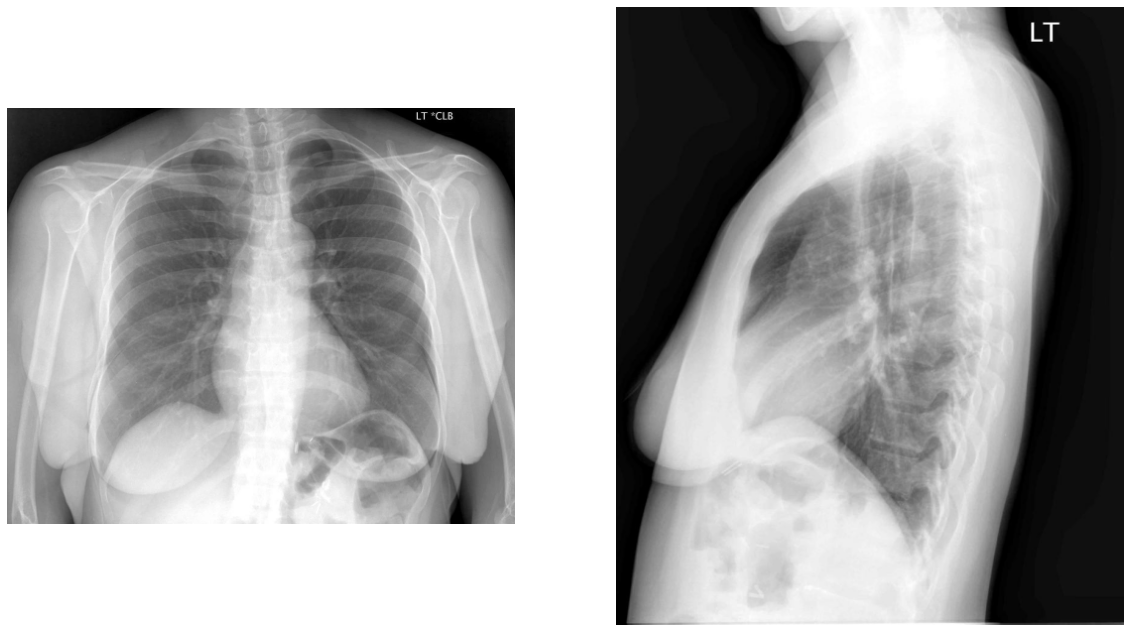


True caption: 'no acute or active cardiac pulmonary or pleural disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . no radiographic evidence of metastatic disease in the chest .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality . no radiographic evidence of metastatic disease in the chest .'
Predicted caption(beam search = 5): 'no acute cardiopulmonary abnormality . no radiographic evidence of metastatic disease in the chest .'
Predicted caption(beam search = 7): 'no acute cardiopulmonary abnormality . no radiographic evidence of metastatic disease in the chest .'


In [97]:
k = 1041
image1,image2 = test['image_1'][k],test['image_2'][k]
true_caption = test['impression'][k]
inference(image1,image2,true_caption)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1442 + 1) instead
  """Entry point for launching an IPython kernel.


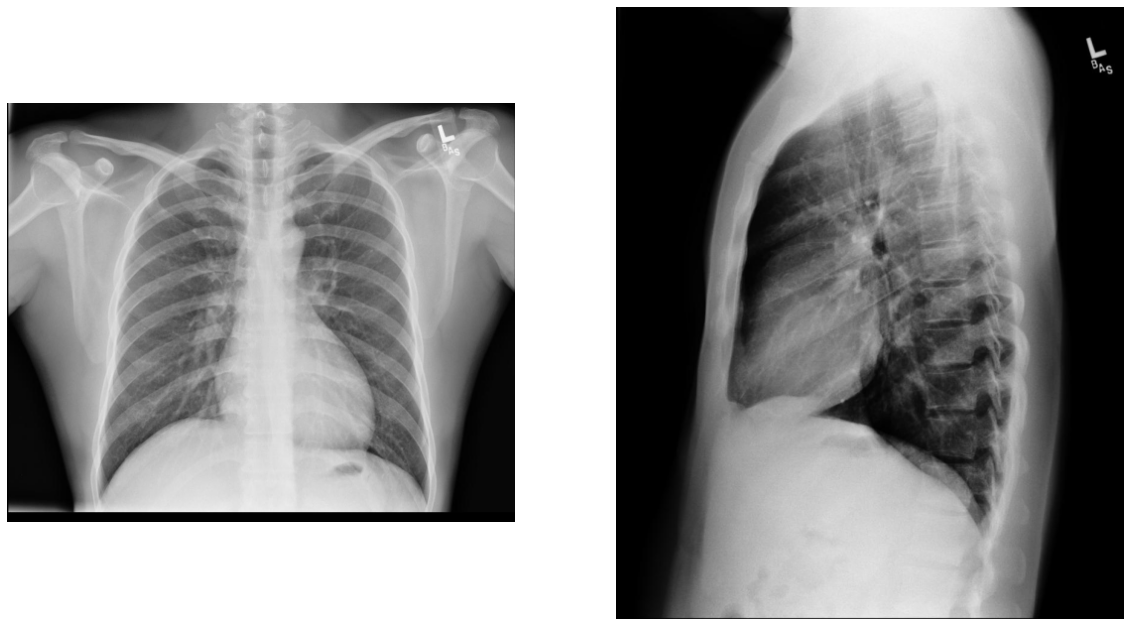


True caption: 'normal heart size . normal pulmonary vasculature . normal mediastinal contours . lung parenchyma is clear . no airspace disease . no pulmonary edema . no of pleural effusions . no of active tuberculosis . no of active cardiopulmonary disease .'
Predicted caption(greedy search): 'no acute cardiopulmonary abnormality . stable chest .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary abnormality . stable chest .'
Predicted caption(beam search = 5): 'no acute cardiopulmonary abnormality . stable chest .'
Predicted caption(beam search = 7): 'no acute cardiopulmonary abnormality . stable chest .'


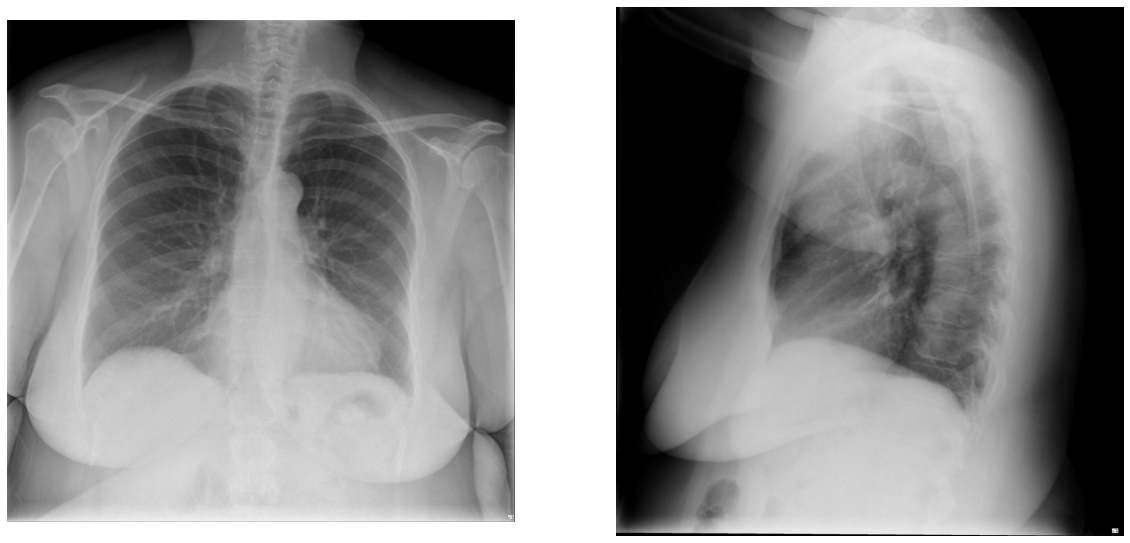


True caption: 'interval removal of stent without acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'no acute cardiopulmonary disease .'
Predicted caption(beam search = 3): 'no acute cardiopulmonary disease .'
Predicted caption(beam search = 5): 'no acute cardiopulmonary disease .'
Predicted caption(beam search = 7): 'no acute cardiopulmonary disease .'


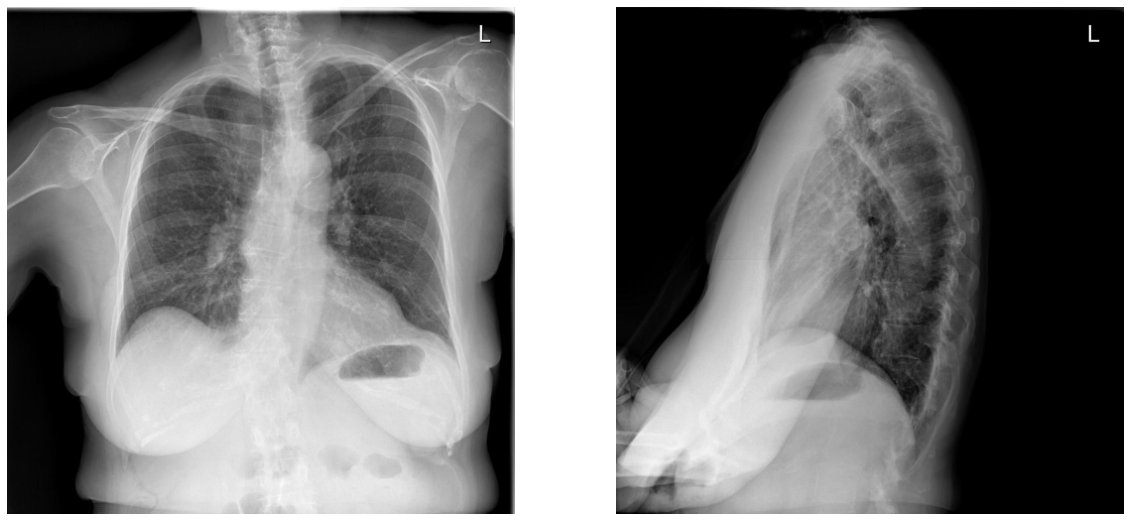


True caption: 'no evidence of active disease .'
Predicted caption(greedy search): 'findings of chronic obstructive pulmonary disease .'
Predicted caption(beam search = 3): 'findings of chronic obstructive pulmonary disease .'
Predicted caption(beam search = 5): 'findings of chronic obstructive pulmonary disease .'
Predicted caption(beam search = 7): 'findings of chronic obstructive pulmonary disease .'


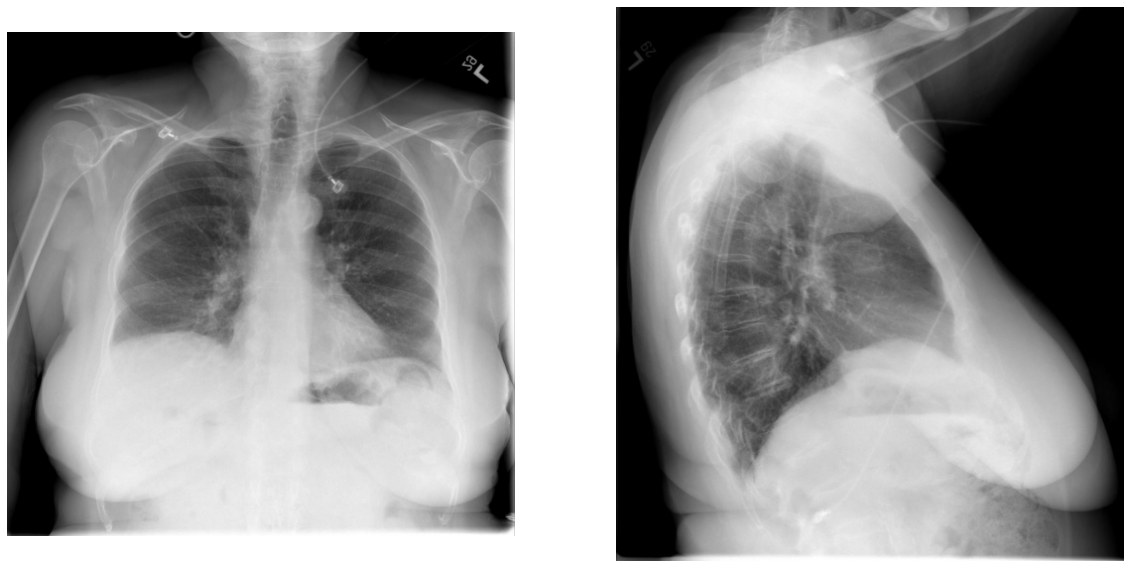


True caption: 'no acute cardiopulmonary abnormality .'
Predicted caption(greedy search): 'right lower lobe airspace disease with small bilateral pleural effusions .'
Predicted caption(beam search = 3): 'right lower lobe airspace disease with small bilateral pleural effusions .'
Predicted caption(beam search = 5): 'right lower lobe airspace disease with small bilateral pleural effusions .'
Predicted caption(beam search = 7): 'right lower lobe airspace disease with small bilateral pleural effusions .'


In [ ]:
sample_i = np.random.random_integers(0,test.shape[0]-1,size = (5,)) #low and high are inclusive, 10 samples

for k in sample_i:
  image1,image2 = test['image_1'][k],test['image_2'][k]
  true_caption = test['impression'][k]
  inference(image1,image2,true_caption)

In [88]:
test.shape[0]

1443